<a href="https://colab.research.google.com/github/artakhm/HomeCredit/blob/master/home_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
sns.set(style="darkgrid")
!pip install imbalanced-learn
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score,roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, cross_validate,train_test_split
from google.colab import drive  
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/drive


In [2]:
train = pd.read_csv('/content/drive/My Drive/HomeCredit/train.csv')

In [3]:
train.shape

(307511, 657)

In [4]:
train.head()

,Unnamed: 0,Unnamed: 0.1,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,id_balance_STATUS_5_mean_min,id_balance_STATUS_5_mean_max,id_balance_STATUS_5_mean_mean,id_balance_STATUS_5_mean_sum,id_balance_STATUS_5_sum_min,id_balance_STATUS_5_sum_max,id_balance_STATUS_5_sum_mean,id_balance_STATUS_5_sum_sum,id_balance_STATUS_C_min_min,id_balance_STATUS_C_min_max,id_balance_STATUS_C_min_mean,id_balance_STATUS_C_min_sum,id_balance_STATUS_C_max_min,id_balance_STATUS_C_max_max,id_balance_STATUS_C_max_mean,id_balance_STATUS_C_max_sum,id_balance_STATUS_C_mean_min,id_balance_STATUS_C_mean_max,id_balance_STATUS_C_mean_mean,id_balance_STATUS_C_mean_sum,id_balance_STATUS_C_sum_min,id_balance_STATUS_C_sum_max,id_balance_STATUS_C_sum_mean,id_balance_STATUS_C_sum_sum,id_balance_STATUS_X_min_min,id_balance_STATUS_X_min_max,id_balance_STATUS_X_min_mean,id_balance_STATUS_X_min_sum,id_balance_STATUS_X_max_min,id_balance_STATUS_X_max_max,id_balance_STATUS_X_max_mean,id_balance_STATUS_X_max_sum,id_balance_STATUS_X_mean_min,id_balance_STATUS_X_mean_max,id_balance_STATUS_X_mean_mean,id_balance_STATUS_X_mean_sum,id_balance_STATUS_X_sum_min,id_balance_STATUS_X_sum_max,id_balance_STATUS_X_sum_mean,id_balance_STATUS_X_sum_sum
0,0,0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,9.0,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75,6.0,0.0,0.8125,0.175426,1.403409,0.0,13.0,2.875,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75,6.0,0.0,0.5,0.161932,1.295455,0.0,3.0,1.875,15.0
1,1,1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,9.0,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,0.535276,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0
2,2,2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.505998,0.555912,0.729567,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0
3,3,3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,9.0,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.505998,0.650442,0.535276,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0
4,4,4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,9.0,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.505998,0.322738,0.535276,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0


In [5]:
X=train.drop(columns=['TARGET', 'Unnamed: 0','Unnamed: 0.1','SK_ID_CURR'])
y=train['TARGET']

## Feature Importances

In [6]:
X['TARGET'] = y
correlations = X.corr()['TARGET'].sort_values()
X.drop(columns=['TARGET'], )
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_LAST_PHONE_CHANGE                    0.055218
PREV_CODE_REJECT_REASON_SCOFR_MEAN        0.055247
NAME_INCOME_TYPE_Working                  0.057481
PREV_NAME_PRODUCT_TYPE_walk-in_MEAN       0.057810
REGION_RATING_CLIENT                      0.058899
REGION_RATING_CLIENT_W_CITY               0.060893
DAYS_EMPLOYED                             0.063368
bureau_DAYS_ENDDATE_FACT_mean             0.067175
bureau_DAYS_ENDDATE_FACT_min              0.068892
bureau_DAYS_CREDIT_UPDATE_mean            0.069687
bureau_DAYS_CREDIT_min                    0.072869
PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.077894
DAYS_BIRTH                                0.078239
bureau_DAYS_CREDIT_mean                   0.083960
TARGET                                    1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_2                              -0.160295
EXT_SOURCE_3                              -0.155892
EXT_SOURCE_1                              -

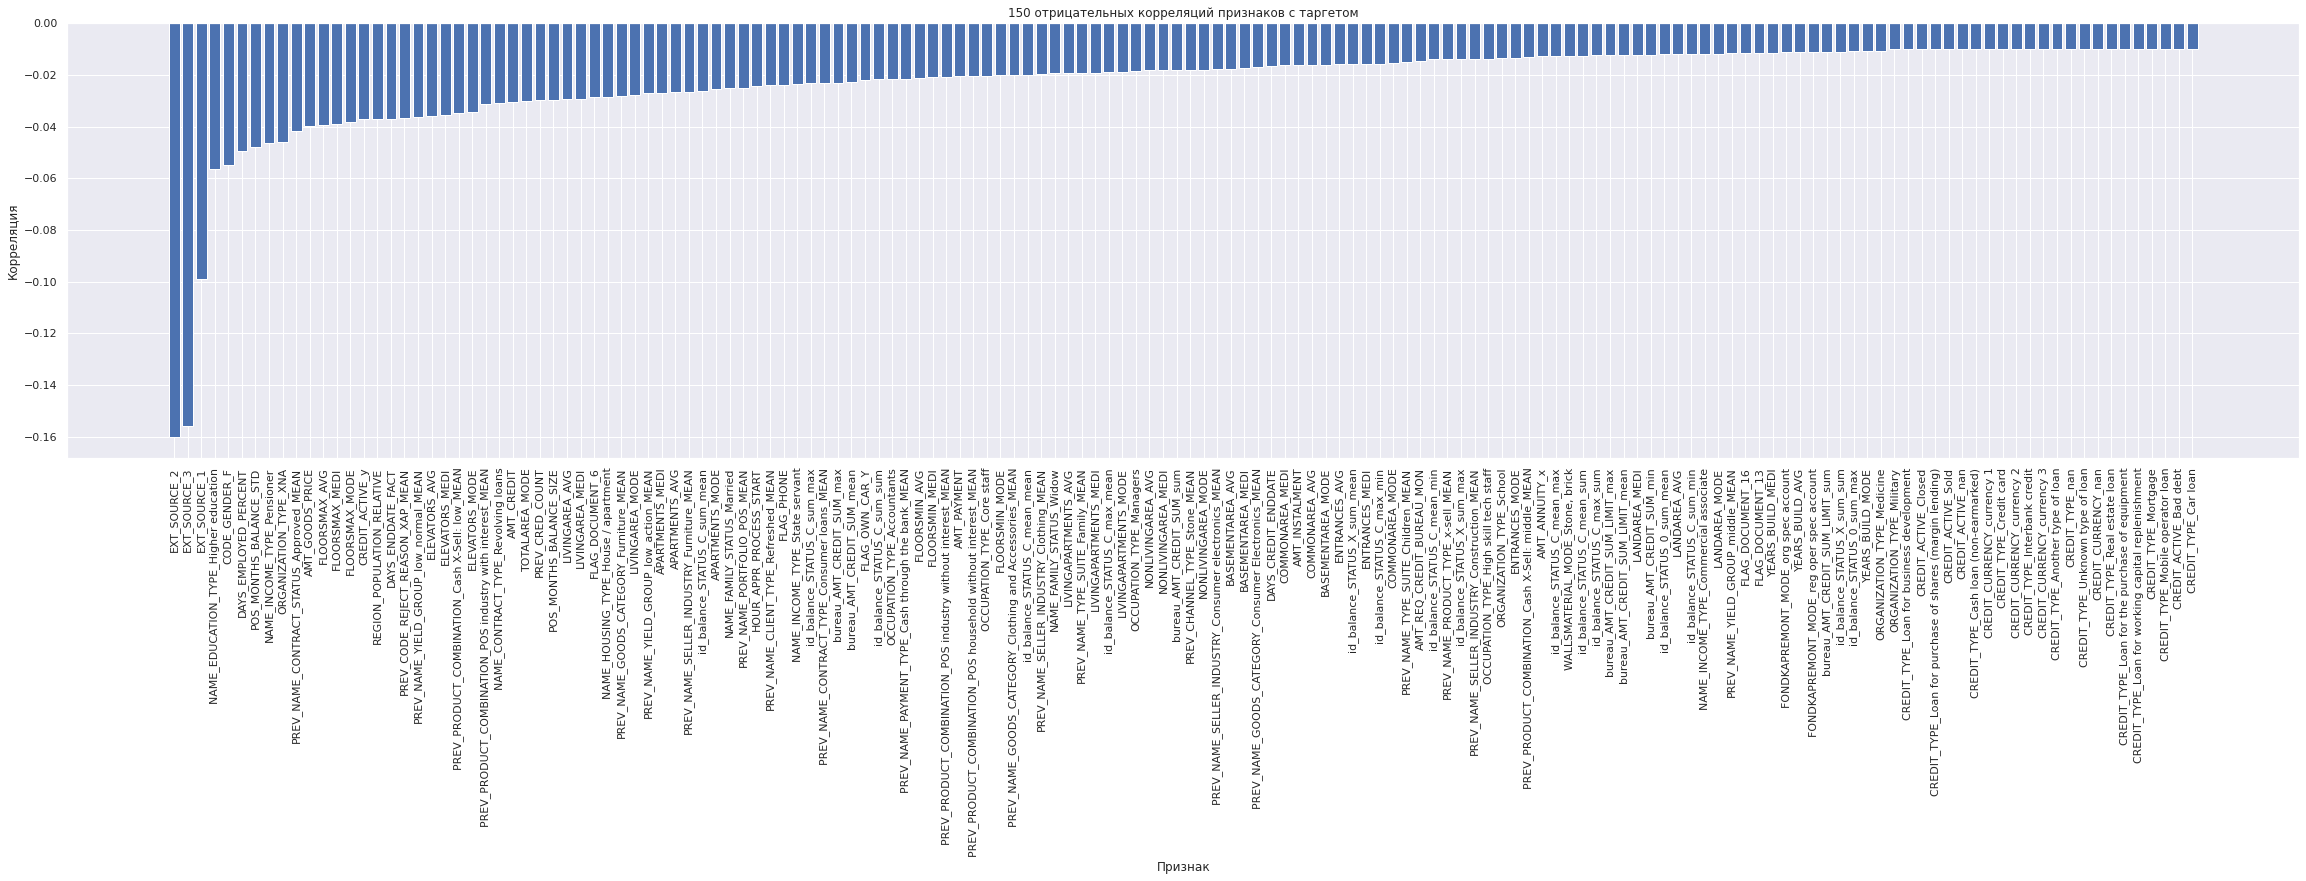

In [21]:
plt.figure(figsize=(40, 8))
plt.xlabel('Признак')
plt.ylabel('Корреляция')
plt.title('150 отрицательных корреляций признаков с таргетом')
plt.bar(correlations.index[:150], correlations[:150])
plt.xticks(rotation=90)
plt.savefig('corr2')
plt.show()

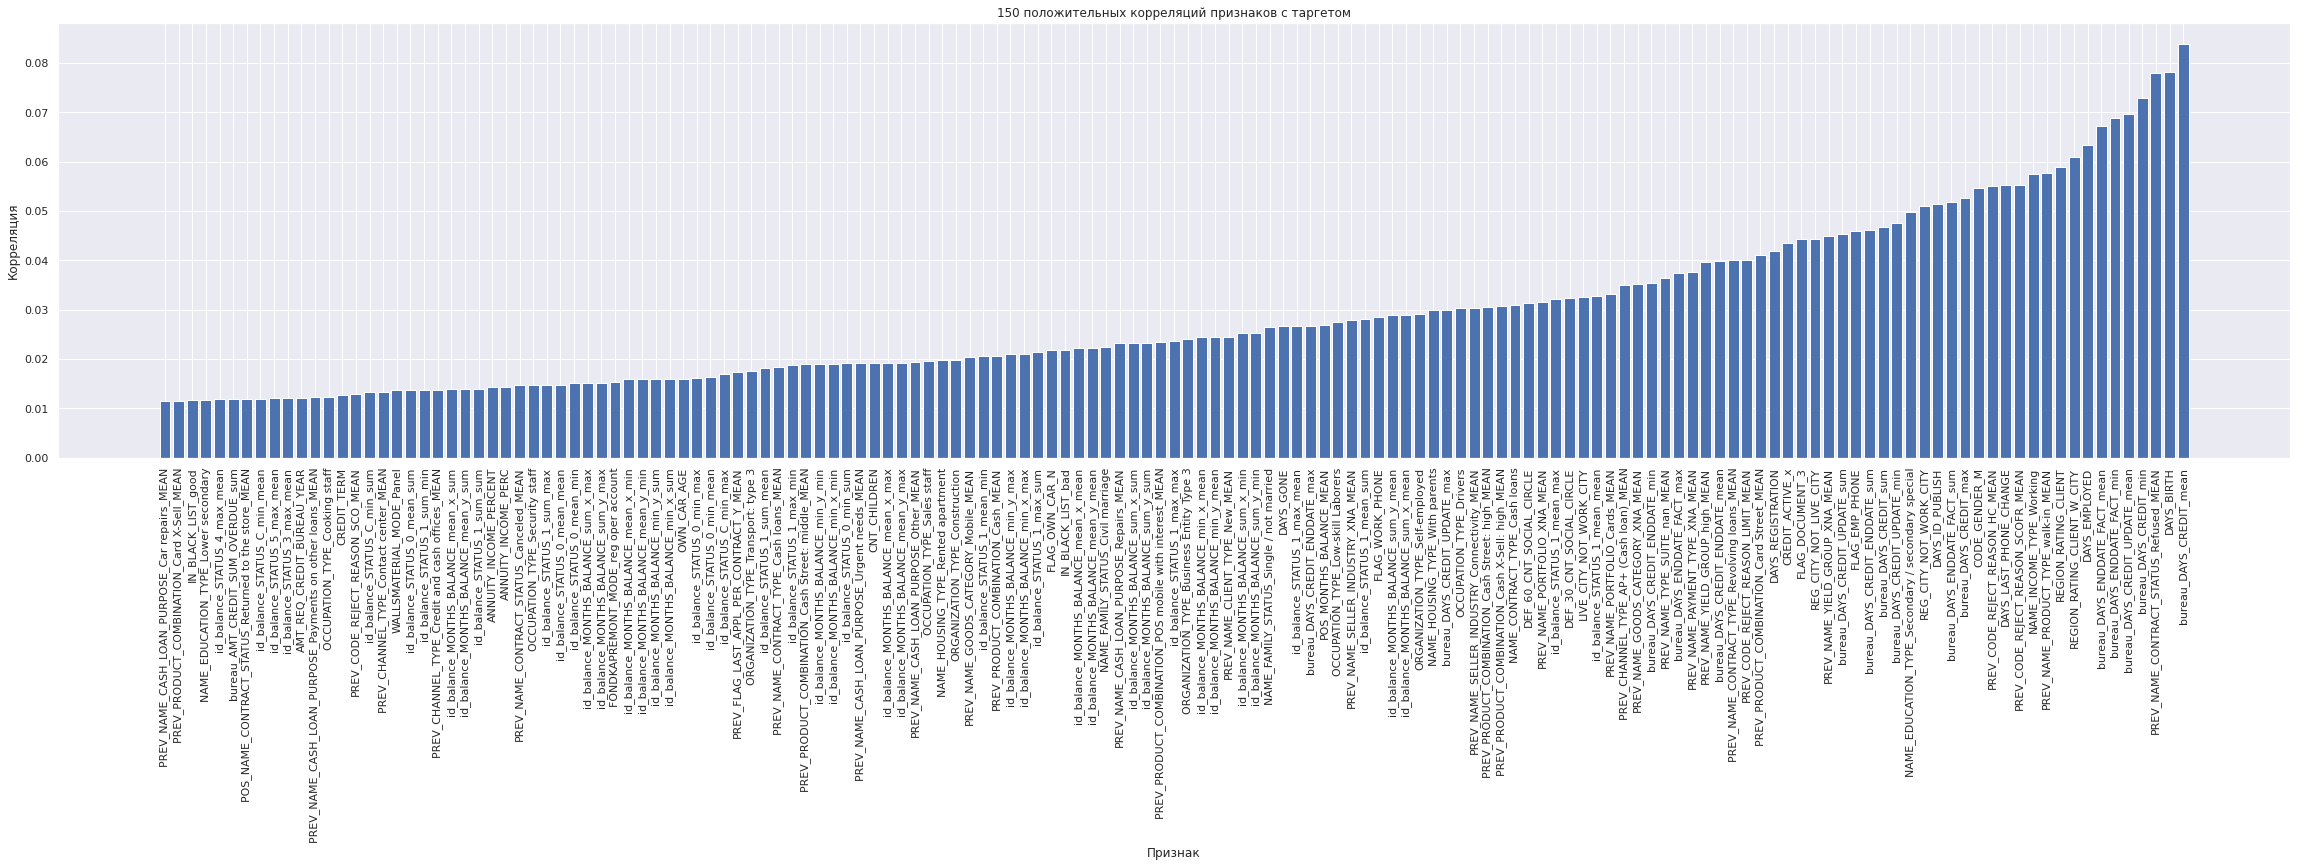

In [22]:
plt.figure(figsize=(40, 8))
plt.xlabel('Признак')
plt.ylabel('Корреляция')
plt.title('150 положительных корреляций признаков с таргетом')
plt.bar(correlations.index[-150:-1], correlations[-150:-1])
plt.xticks(rotation=90)
plt.savefig('corr1')
plt.show()

In [ ]:
gb_clf = XGBClassifier(n_estimators=1000,  tree_method='gpu_hist', objective= 'binary:logistic', eval_metric='auc', scale_pos_weight=balance).fit(X_train, y_train)

In [ ]:
print('accuracy_score:', accuracy_score(y_test, gb_clf.predict(X_test)))
print('precision_score:', precision_score(y_test, gb_clf.predict(X_test)))
print('recall_score:', recall_score(y_test, gb_clf.predict(X_test)))
print('roc_auc_score:',roc_auc_score(y_test, gb_clf.predict_proba(X_test)[:, 1]))

In [ ]:
# feat_imp = gb_clf.feature_importances_

In [23]:
feat_imp = pd.read_csv('/content/drive/My Drive/HomeCredit/feat_imps.csv')

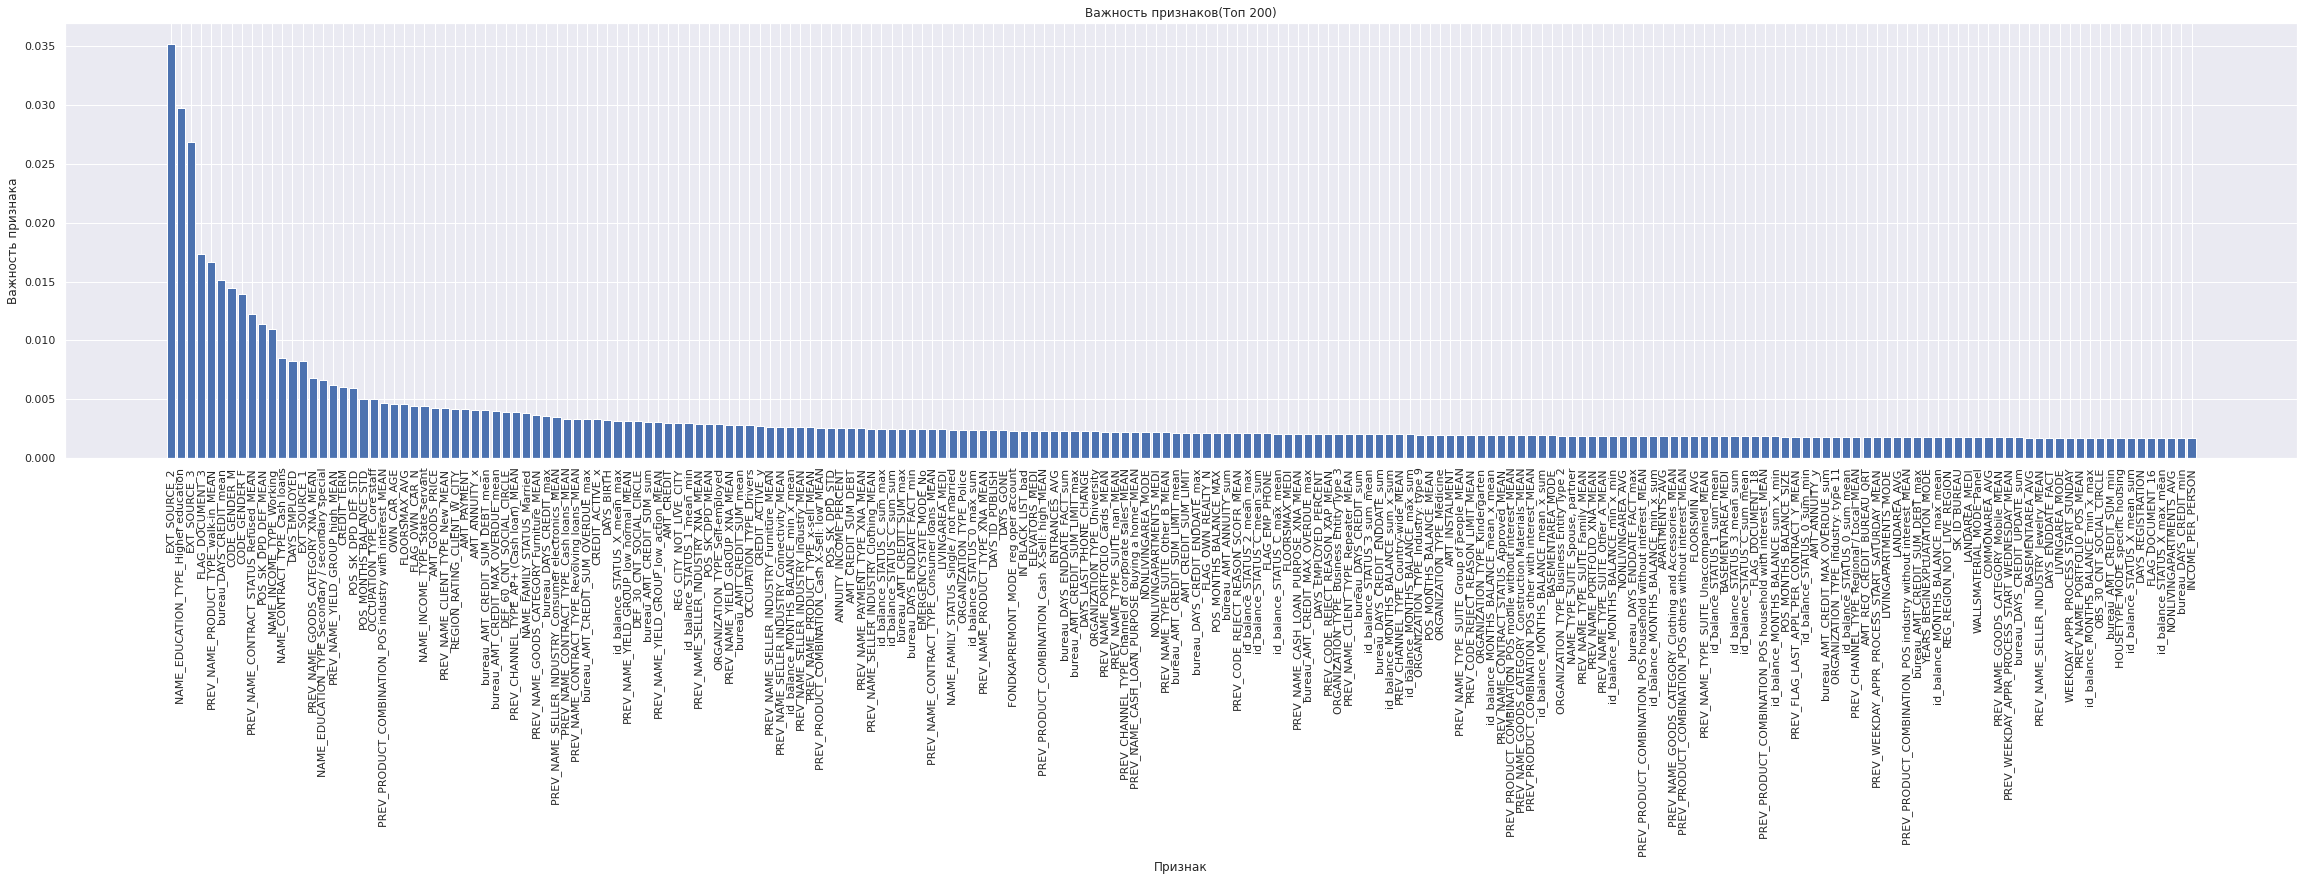

In [ ]:
plt.figure(figsize=(40, 8))
plt.xlabel('Признак')
plt.ylabel('Важность признака')
plt.title('Важность признаков(Топ 200)')
plt.bar(feat_imp['Unnamed: 0'][:200],feat_imp['0'][:200])
plt.xticks(rotation=90)
# plt.savefig('feature_importances_100')
plt.show()


In [24]:
best_feats = feat_imp['Unnamed: 0'][:300].to_list()

In [25]:
X = X[best_feats]

На хитмапе много признаков не видно будет, поэтому только 50 признаков.

In [33]:
X_corr=X[feat_imp['Unnamed: 0'][:50].to_list()]
X_corr['TARGET']=y
corrMatrix = X_corr.corr()

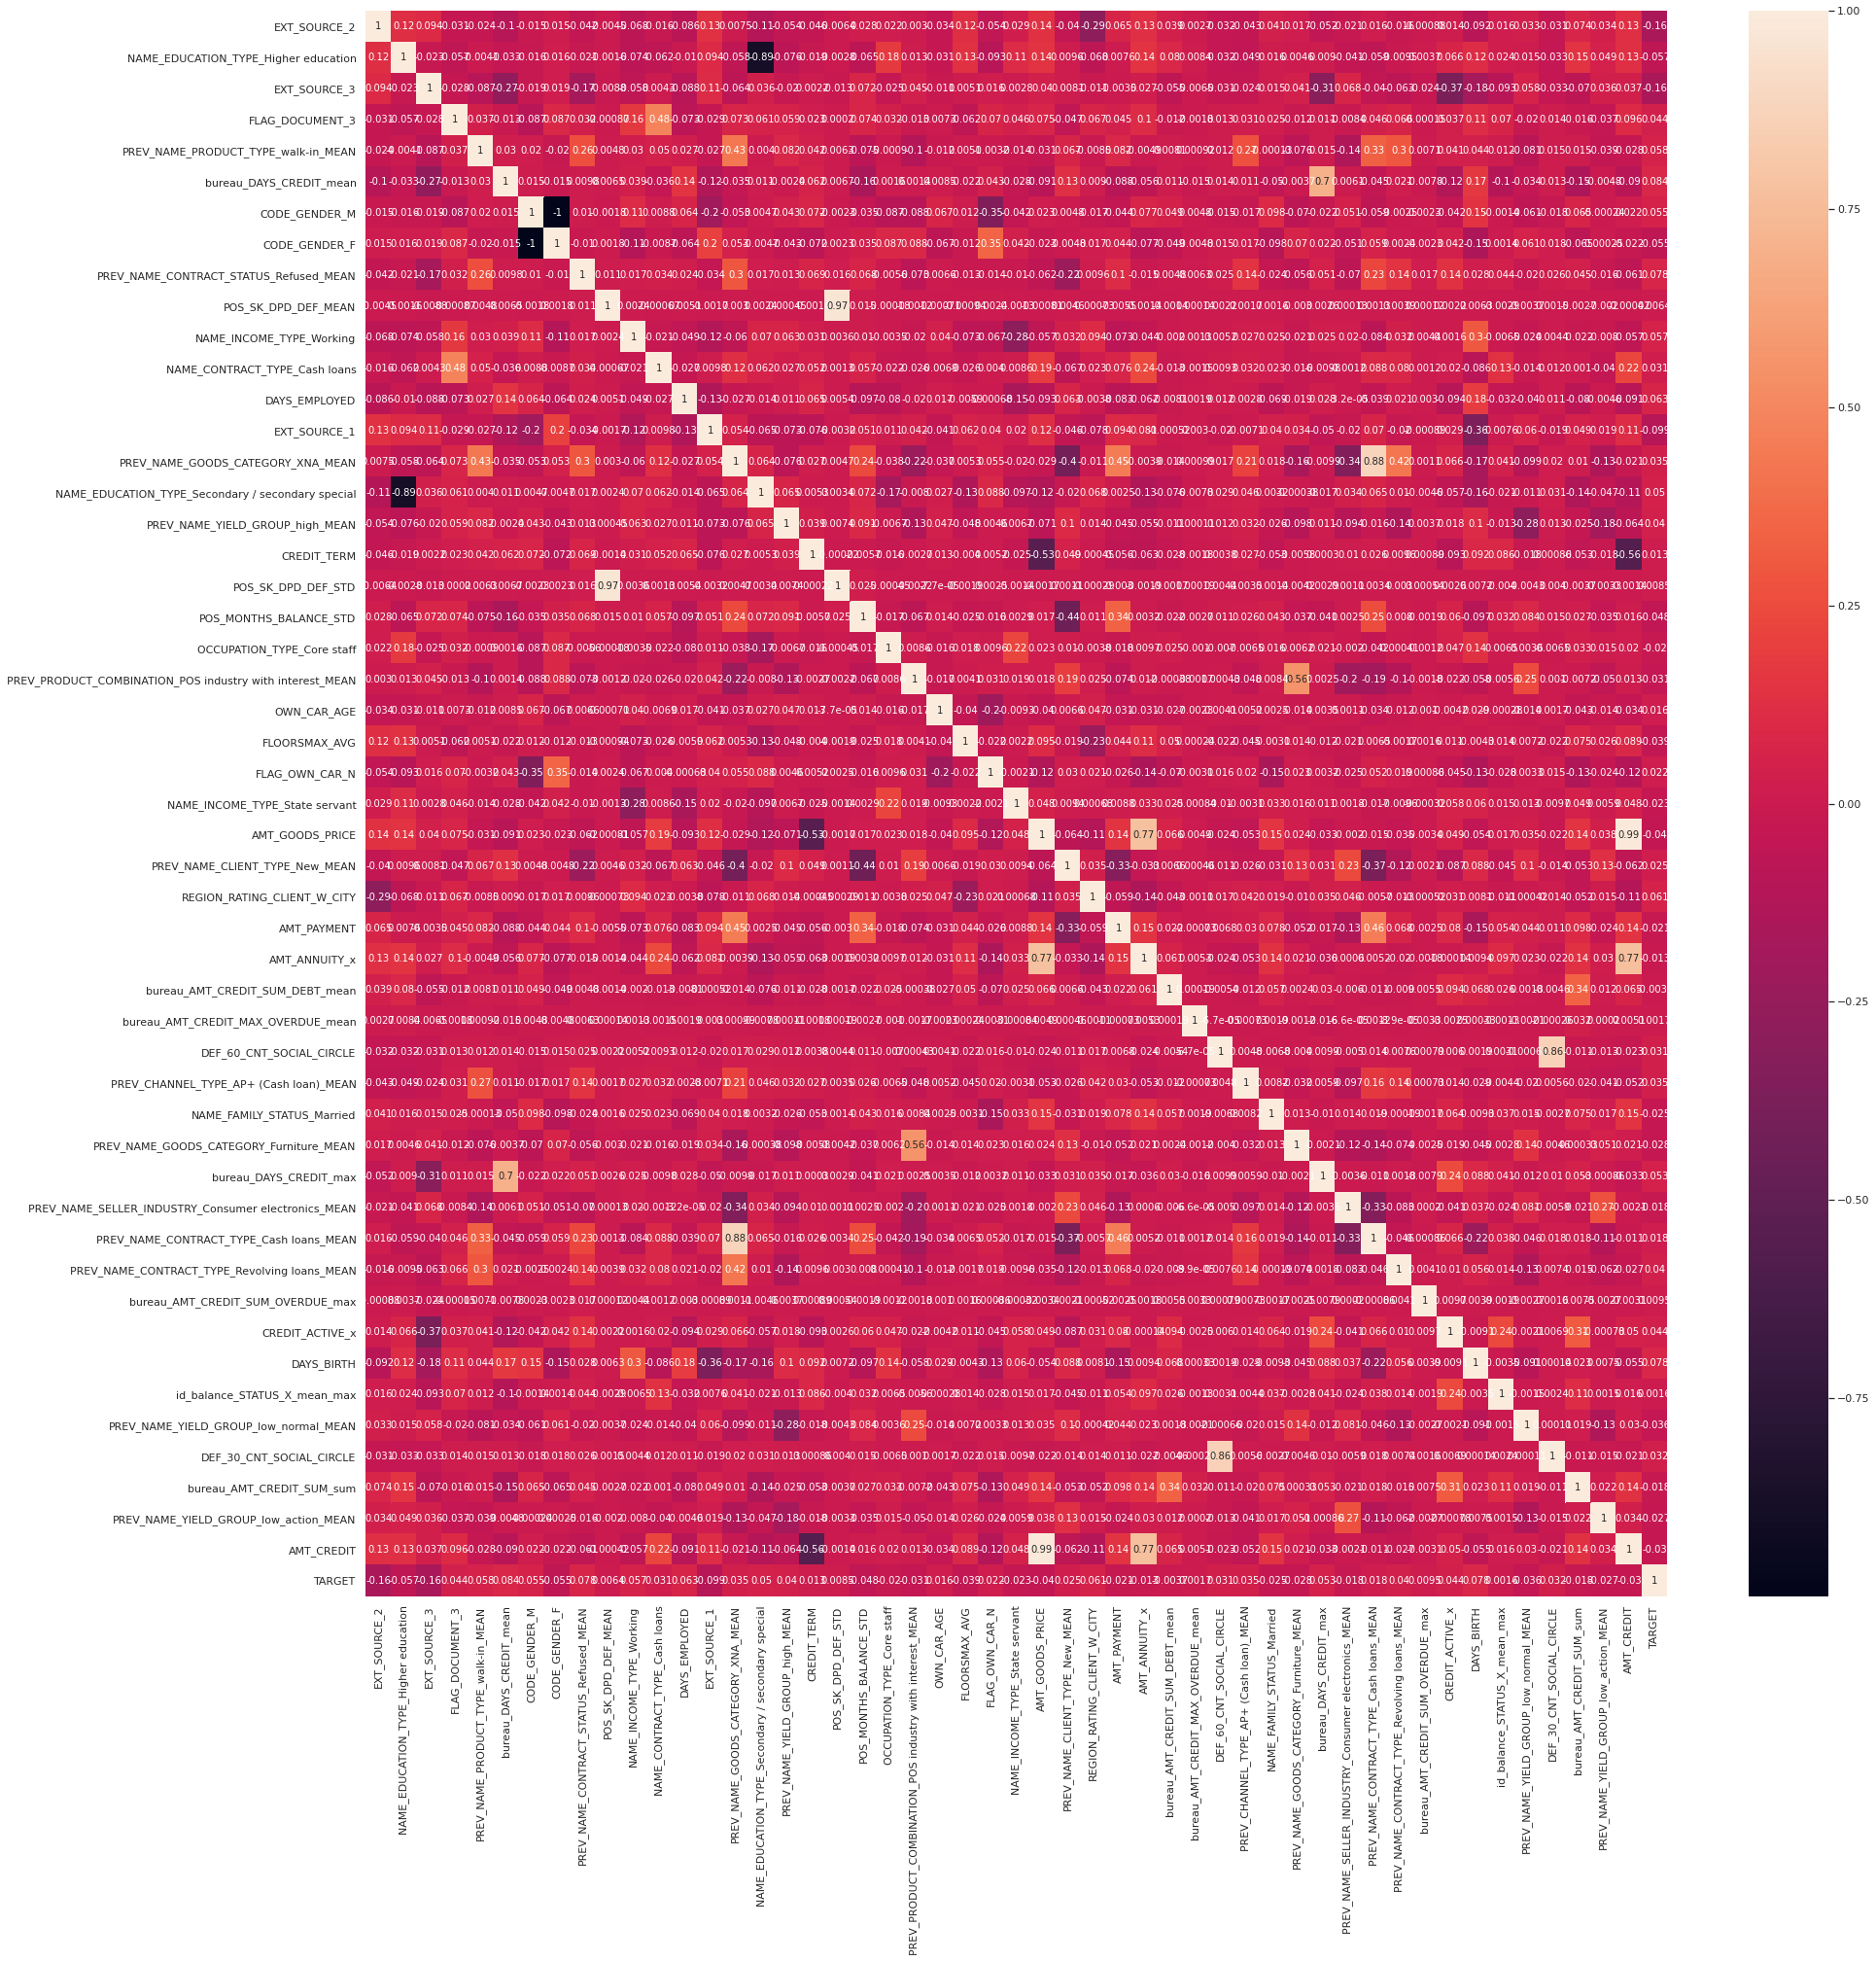

In [34]:
plt.figure(figsize=(30, 30))
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Undersampling and Normalize

In [ ]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [ ]:
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_und, y_und = undersample.fit_resample(X, y)

## Модель

### Logreg

In [ ]:
params = {
    'penalty': ['l1','l2'],
    'tol': [1e-3,1e-4,1e-5],
    'C':[0.25, 0.5, 1,1.25, 1.5],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'max_iter': [500, 1000, 1500, 2000]
}

model = LogisticRegression()

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, refit='roc_auc', n_jobs=1, n_iter=80, verbose=0, random_state=42)

grid.fit(X_und, y_und)
print(f'{grid.best_estimator_}, {grid.best_score_}')

In [ ]:
model = grid.best_estimator_
scores = cross_validate(model, X_und, y_und, scoring=[
                        'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, return_train_score=True, n_jobs=1)

i_accuracy = np.mean(scores['test_accuracy'])
i_roc_auc = np.mean(scores['test_roc_auc'])
i_precision = np.mean(scores['test_precision'])
i_recall = np.mean(scores['test_recall'])

print('accuracy: %.3f | roc_auc: %.3f | precision: %.3f | recall: %.3f' % (i_accuracy, i_roc_auc, i_precision, i_recall))

accuracy: 0.730 | roc_auc: 0.758 | precision: 0.644 | recall: 0.426


### Random Forest

In [ ]:
params = {
    'n_estimators': [5000],
    'criterion':['gini', 'entropy']
}

model = RandomForestClassifier()

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, refit='roc_auc', n_jobs=1, n_iter=80, verbose=0, random_state=42)

grid.fit(X_und, y_und)
print(f'{grid.best_estimator_}, {grid.best_score_}')

In [ ]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
scores = cross_validate(model, X_und, y_und, scoring=[
                        'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, return_train_score=True, n_jobs=1)

i_accuracy = np.mean(scores['test_accuracy'])
i_roc_auc = np.mean(scores['test_roc_auc'])
i_precision = np.mean(scores['test_precision'])
i_recall = np.mean(scores['test_recall'])

print('accuracy: %.3f | roc_auc: %.3f | precision: %.3f | recall: %.3f' % (i_accuracy, i_roc_auc, i_precision, i_recall))

accuracy: 0.725 | roc_auc: 0.760 | precision: 0.696 | recall: 0.311


### GB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
balance = train[train.TARGET ==0].TARGET.count() / train[train.TARGET ==1 ].TARGET.count()

#### LightGBM

In [ ]:
params = {
    'reg_alpha': [0, 0.25, 0.5],
    'reg_lambda': [0, 0.25, 0.5],
    'n_estimators': [500, 750, 1000, 1250],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [i for i in range(2, 6)],
    'min_data_in_leaf': [20, 50, 100]
}

model = LGBMClassifier(boosting_type='gbdt', random_state=42, n_jobs=-1,
                       subsample=0.4, neg_bagging_fraction=0.1, verbose=-1)

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc'], cv=3, refit='roc_auc', n_jobs=1, n_iter=80, verbose=0, random_state=42)

grid.fit(X_train, y_train)
print(f'{grid.best_estimator_}, {grid.best_score_}')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=2,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=100, min_split_gain=0.0, n_estimators=1250,
               n_jobs=-1, neg_bagging_fraction=0.1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0, reg_lambda=0.25,
               silent=True, subsample=0.4, subsample_for_bin=200000,
               subsample_freq=0, verbose=-1), 0.7763610599661934


In [ ]:
model = LGBMClassifier(boosting_type='gbdt',learning_rate=0.1, max_depth=2, min_data_in_leaf=100, n_estimators=1250, reg_alpha=0,reg_lambda=0.25 , random_state=42, n_jobs=-1, neg_bagging_fraction=0.1, verbose=-1).fit(X_train, y_train)

print('accuracy_score:', accuracy_score(y_test, model.predict(X_test)))
print('precision_score:', precision_score(y_test, model.predict(X_test)))
print('recall_score:', recall_score(y_test, model.predict(X_test)))
print('roc_auc_score:',roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

accuracy_score: 0.9206542770271369
precision_score: 0.5934959349593496
recall_score: 0.0442513639119014
roc_auc_score: 0.7819820306247393


#### XGBClassifier

In [ ]:
gb_clf = XGBClassifier(learning_rate=0.1, max_depth=2, min_data_in_leaf=100, n_estimators=1250, reg_alpha=0,reg_lambda=0.25,  tree_method='gpu_hist', objective= 'binary:logistic', eval_metric='auc', scale_pos_weight=balance).fit(X_train, y_train)

In [ ]:
print('accuracy_score:', accuracy_score(y_test, gb_clf.predict(X_test)))
print('precision_score:', precision_score(y_test, gb_clf.predict(X_test)))
print('recall_score:', recall_score(y_test, gb_clf.predict(X_test)))
print('roc_auc_score:',roc_auc_score(y_test, gb_clf.predict_proba(X_test)[:, 1]))

accuracy_score: 0.7233793473489099
precision_score: 0.18118393234672303
recall_score: 0.6926651848858355
roc_auc_score: 0.7791291647270956


In [ ]:
gb_clf = XGBClassifier(learning_rate=0.05, max_depth=2, min_data_in_leaf=100, n_estimators=2000, reg_alpha=0,reg_lambda=0.25,  tree_method='gpu_hist', objective= 'binary:logistic', eval_metric='auc', scale_pos_weight=balance).fit(X_train, y_train)

In [ ]:
print('accuracy_score:', accuracy_score(y_test, gb_clf.predict(X_test)))
print('precision_score:', precision_score(y_test, gb_clf.predict(X_test)))
print('recall_score:', recall_score(y_test, gb_clf.predict(X_test)))
print('roc_auc_score:',roc_auc_score(y_test, gb_clf.predict_proba(X_test)[:, 1]))

accuracy_score: 0.7207128107571988
precision_score: 0.17972760607647983
recall_score: 0.6932713679531218
roc_auc_score: 0.7787409777559733


In [ ]:
params = {
    'reg_alpha': [0, 0.25, 0.5],
    'reg_lambda': [0, 0.25, 0.5],
    'n_estimators': [1000, 1500, 2000,2500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [i for i in range(2, 6)],
    'min_data_in_leaf': [20, 50, 100]
}

model = XGBClassifier(tree_method='gpu_hist', objective= 'binary:logistic', 
                      eval_metric='auc', scale_pos_weight=balance, subsample=0.4)

grid = RandomizedSearchCV(model, params, scoring=[
    'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, refit='roc_auc', n_jobs=1, n_iter=80, verbose=0, random_state=42)

grid.fit(X_train, y_train)
print(f'{grid.best_estimator_}, {grid.best_score_}')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_data_in_leaf=100, missing=None,
              n_estimators=2000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0.25,
              reg_lambda=0, scale_pos_weight=11.387150050352467, seed=None,
              silent=None, subsample=0.4, tree_method='gpu_hist', verbosity=1), 0.7731921697243959


In [ ]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_data_in_leaf=100, n_estimators=2000, n_jobs=-1,
              objective='binary:logistic', random_state=0, reg_alpha=0.25,
              reg_lambda=0, scale_pos_weight=11.387150050352467, tree_method='gpu_hist', verbosity=1)

scores = cross_validate(model, X_train, y_train, scoring=[
                        'accuracy', 'roc_auc', 'precision', 'recall'], cv=3, return_train_score=True, n_jobs=1)

i_accuracy = np.mean(scores['test_accuracy'])
i_roc_auc = np.mean(scores['test_roc_auc'])
i_precision = np.mean(scores['test_precision'])
i_recall = np.mean(scores['test_recall'])

print('accuracy: %.3f | roc_auc: %.3f | precision: %.3f | recall: %.3f' % (i_accuracy, i_roc_auc, i_precision, i_recall))

accuracy: 0.726 | roc_auc: 0.772 | precision: 0.180 | recall: 0.673


In [ ]:
gb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_data_in_leaf=100, n_estimators=2000, n_jobs=-1,
              objective='binary:logistic', random_state=0, reg_alpha=0.25,
              reg_lambda=0, scale_pos_weight=11.387150050352467, tree_method='gpu_hist', verbosity=1).fit(X_train, y_train)
              
print('accuracy_score:', accuracy_score(y_test, gb_clf.predict(X_test)))
print('precision_score:', precision_score(y_test, gb_clf.predict(X_test)))
print('recall_score:', recall_score(y_test, gb_clf.predict(X_test)))
print('roc_auc_score:',roc_auc_score(y_test, gb_clf.predict_proba(X_test)[:, 1]))

accuracy_score: 0.7205339576931207
precision_score: 0.1783442838370565
recall_score: 0.6855930491008284
roc_auc_score: 0.7752797439709559
